# Home Credit Default Risk

We have a dataframe in which are registered a lot of information about a bank's clients.

The bank wants to know if they should give them a loan or not. The machine learning model needs to predict if the client will repay the loan or not.

If the target is equal to 0: the loan was repaid, if it's equal to 1: the loan was not repaid.

The models will determine if the loan will be repaid or not according to the given features.

# Summary

* Data observation
* Data cleanup
* Boruta 

Machine Learning Models: 
* KNeighbors Classifier using Grid Search
* Logistic Regression
* Decision Tree
* Random Forest
* XGBoost

* Comparing models predictions on application test

# Library used

In [305]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import graphviz

# Undersampling
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

# Machine Learning Library
from sklearn import metrics
from sklearn.metrics import multilabel_confusion_matrix, classification_report, accuracy_score, precision_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
import joblib

# Grid Search
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# Boruta
from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy as bp
from sklearn.datasets import load_boston

# KNeighbors Classifier
from sklearn.neighbors import KNeighborsClassifier

# Logistic Regression
from sklearn.linear_model import LogisticRegression

# Decision Tree
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

# Random Forest
from sklearn.ensemble import RandomForestClassifier

# XGBoost
import xgboost as xgb

from warnings import filterwarnings
filterwarnings('ignore')

## Data

In [306]:
app_train = pd.read_csv("./resources/application_train.csv", encoding='utf-8', sep=',')
app_test = pd.read_csv("./resources/application_test.csv", encoding='utf-8', sep=',')
app_train.drop_duplicates()
app_test.drop_duplicates()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,456221,Cash loans,F,N,Y,0,121500.0,412560.0,17473.5,270000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
48740,456222,Cash loans,F,N,N,2,157500.0,622413.0,31909.5,495000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
48741,456223,Cash loans,F,Y,Y,1,202500.0,315000.0,33205.5,315000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,3.0,1.0
48742,456224,Cash loans,M,N,N,0,225000.0,450000.0,25128.0,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0


## Aligning the two datasets

In [307]:
train_labels = app_train['TARGET']
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)
app_train['TARGET'] = train_labels
print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 122)
Testing Features shape:  (48744, 121)


# Data Analysis

In [308]:
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

## Is data unbalanced ? 

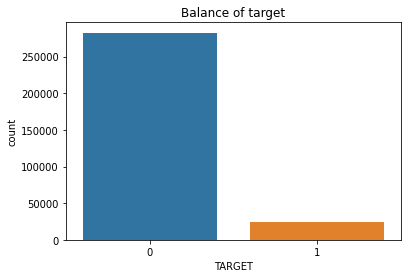

Unbalanced data on the TARGET column:
0    282686
1     24825
Name: TARGET, dtype: int64


In [309]:
fig = sns.countplot(x="TARGET", data=app_train)
plt.title('Balance of target')
plt.show()
print("Unbalanced data on the TARGET column:")
print(app_train['TARGET'].value_counts())

The data is very unbalanced.

## Gender distribution

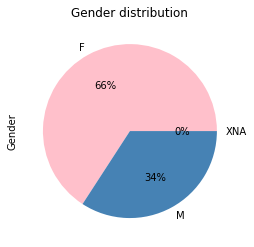

In [310]:
gender_group = app_train.groupby(['CODE_GENDER'])
gender_group.size().plot(kind='pie', 
                         ylabel='Gender', 
                         colors=['pink', 'steelblue', 'pink'], 
                         title='Gender distribution',
                         autopct='%.0f%%')
plt.show()

### Contract type distribution

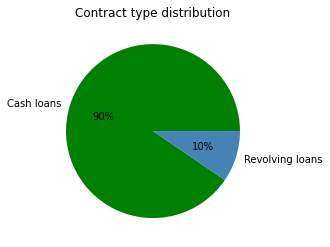

In [311]:
contract_group = app_train.groupby(['NAME_CONTRACT_TYPE'])
contract_group.size().plot(kind='pie', 
                           ylabel='', 
                           colors=['green', 'steelblue'], 
                           title='Contract type distribution',
                           autopct='%.0f%%')
plt.show()

## Days Birth feature

### Informations

In [312]:
(app_train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

### Minimum and maximum value

In [313]:
mini = abs(app_train['DAYS_BIRTH'].max())
if mini > 365:
    print("Days birth min :", mini/365, "days" )
else:
    print("Days birth min :", mini, "days" )
    
maxi = abs(app_train['DAYS_BIRTH'].min())
print("Days birth max :", maxi/365, "years" )

Days birth min : 20.517808219178082 days
Days birth max : 69.12054794520547 years


### Boxplots

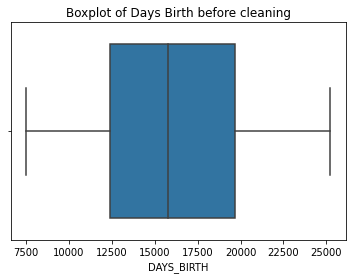

In [314]:
ax = sns.boxplot(x=abs(app_train['DAYS_BIRTH']))
plt.title('Boxplot of Days Birth before cleaning')
plt.show()

## Missing values

In [315]:
print("30 first columns filled with the most NaN values with their percentage:")
((app_train.isnull().sum()/app_train.shape[0])*100).sort_values(ascending=False).head(30)

30 first columns filled with the most NaN values with their percentage:


COMMONAREA_MODE             69.872297
COMMONAREA_AVG              69.872297
COMMONAREA_MEDI             69.872297
NONLIVINGAPARTMENTS_MEDI    69.432963
NONLIVINGAPARTMENTS_AVG     69.432963
NONLIVINGAPARTMENTS_MODE    69.432963
FONDKAPREMONT_MODE          68.386172
LIVINGAPARTMENTS_MEDI       68.354953
LIVINGAPARTMENTS_AVG        68.354953
LIVINGAPARTMENTS_MODE       68.354953
FLOORSMIN_MEDI              67.848630
FLOORSMIN_AVG               67.848630
FLOORSMIN_MODE              67.848630
YEARS_BUILD_AVG             66.497784
YEARS_BUILD_MEDI            66.497784
YEARS_BUILD_MODE            66.497784
OWN_CAR_AGE                 65.990810
LANDAREA_AVG                59.376738
LANDAREA_MODE               59.376738
LANDAREA_MEDI               59.376738
BASEMENTAREA_MODE           58.515956
BASEMENTAREA_MEDI           58.515956
BASEMENTAREA_AVG            58.515956
EXT_SOURCE_1                56.381073
NONLIVINGAREA_AVG           55.179164
NONLIVINGAREA_MODE          55.179164
NONLIVINGARE

# Data cleanup 

## Label encoding

In [316]:
le = LabelEncoder()
le_count = 0

for col in app_train:
    if app_train[col].dtype == 'object' or app_train[col].dtype == 'string':
        le.fit(app_train[col])
        app_train[col] = le.transform(app_train[col])
        app_test[col] = le.transform(app_test[col])
        le_count += 1
        print(col)
app_train.reset_index()
app_test.reset_index()
print('%d columns were label encoded.' % le_count)

NAME_CONTRACT_TYPE
CODE_GENDER
FLAG_OWN_CAR
FLAG_OWN_REALTY
NAME_TYPE_SUITE
NAME_INCOME_TYPE
NAME_EDUCATION_TYPE
NAME_FAMILY_STATUS
NAME_HOUSING_TYPE
OCCUPATION_TYPE
WEEKDAY_APPR_PROCESS_START
ORGANIZATION_TYPE
FONDKAPREMONT_MODE
HOUSETYPE_MODE
WALLSMATERIAL_MODE
EMERGENCYSTATE_MODE
16 columns were label encoded.


## Missing and infinite values

In [317]:
# Replacing Infinite values with NaN values
app_train.replace([np.inf, -np.inf], np.nan, inplace=True)
app_test.replace([np.inf, -np.inf], np.nan, inplace=True)

In [318]:
imputer = SimpleImputer(missing_values=np.nan, strategy="median").fit(app_train)
imputer = imputer.fit_transform(app_train)
app_train = pd.DataFrame(imputer, columns = app_train.columns.values.tolist())

In [319]:
imputer = SimpleImputer(missing_values=np.nan, strategy="median").fit(app_test)
imputer = imputer.fit_transform(app_test)
app_test = pd.DataFrame(imputer, columns = app_test.columns.values.tolist())

## Handling unbalanced data

In [320]:
"""
# Oversampling
msk = app_train['TARGET'] == 1
num_to_oversample = len(app_train) - 2*msk.sum()
df_positive_oversample = app_train[msk].sample(n=num_to_oversample, replace=True)
df_train_oversample = pd.concat([app_train, df_positive_oversample])
app_train = df_train_oversample
print("Balanced data after oversampling:\n")
print(app_train['TARGET'].value_counts())
"""
# Undersampling
X = app_train
Y = np.array(app_train['TARGET'])
X.drop('TARGET', axis=1, inplace=True)

rus = RandomUnderSampler(random_state=0)
app_train, y_resampled = rus.fit_resample(X,Y)
app_train['TARGET'] = y_resampled
print(sorted(Counter(y_resampled).items()), y_resampled.shape)

[(0.0, 24825), (1.0, 24825)] (49650,)


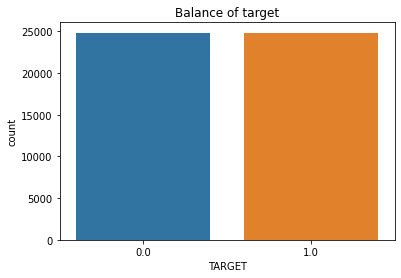

In [321]:
fig = sns.countplot(x="TARGET", data=app_train)
plt.title('Balance of target')
plt.show()

The target column is now balanced, this will allow the models to get better results.

## Days Employed feature

### Informations 

In [322]:
app_train['DAYS_EMPLOYED'].describe()

count     49650.000000
mean      54464.751078
std      132619.746910
min      -16836.000000
25%       -2479.750000
50%       -1115.000000
75%        -331.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

### Minimum and maximum values

In [323]:
mini = abs(app_train['DAYS_EMPLOYED'].max())
if mini > 365:
    print("Days employed min :", mini/365, "years" )
else:
    print("Days employed min :", mini, "days" )
    
maxi = abs(app_train['DAYS_EMPLOYED'].min())
print("Days employed max :", maxi/365, "years" )

Days employed min : 1000.6657534246575 years
Days employed max : 46.12602739726027 years


We can see an anomaly : the biggest 'Days Employed' value is around 1000 years !

### Boxplots

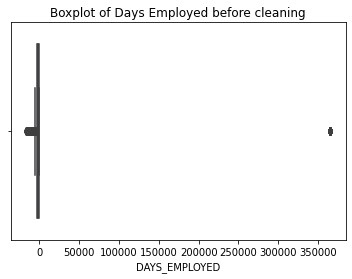

In [324]:
ax = sns.boxplot(x=app_train['DAYS_EMPLOYED'])
plt.title('Boxplot of Days Employed before cleaning')
plt.show()

### Removing anomalies

In [325]:
app_train.drop(app_train.index[(app_train["DAYS_EMPLOYED"] > 12000)], axis=0, inplace=True)
app_test.drop(app_test.index[(app_test["DAYS_EMPLOYED"] > 12000)], axis=0, inplace=True)

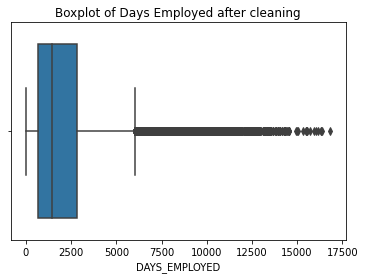

In [326]:
ax = sns.boxplot(x=abs(app_train['DAYS_EMPLOYED']))
plt.title('Boxplot of Days Employed after cleaning')
plt.show()

## Correlations

In [327]:
correlations = app_train.corr()['TARGET'].sort_values()
print('Most Positive Correlations:\n')
print(correlations.tail(15))
print('\nMost Negative Correlations:\n')
print(correlations.head(15))

Most Positive Correlations:

REG_CITY_NOT_WORK_CITY         0.074524
FLAG_DOCUMENT_3                0.079048
WALLSMATERIAL_MODE             0.079689
HOUSETYPE_MODE                 0.084945
CODE_GENDER                    0.086897
EMERGENCYSTATE_MODE            0.088026
DAYS_LAST_PHONE_CHANGE         0.112616
REGION_RATING_CLIENT           0.113341
DAYS_BIRTH                     0.115980
REGION_RATING_CLIENT_W_CITY    0.118288
NAME_EDUCATION_TYPE            0.126593
DAYS_EMPLOYED                  0.145963
TARGET                         1.000000
FLAG_MOBIL                          NaN
FLAG_DOCUMENT_12                    NaN
Name: TARGET, dtype: float64

Most Negative Correlations:

EXT_SOURCE_2                 -0.276415
EXT_SOURCE_3                 -0.260651
EXT_SOURCE_1                 -0.172463
AMT_GOODS_PRICE              -0.096348
FLOORSMAX_AVG                -0.085327
FLOORSMAX_MEDI               -0.084687
FLOORSMAX_MODE               -0.083331
ELEVATORS_AVG                -0.079530


# Splitting data into train and validation

In [328]:
Xdf = app_train.copy()
Xdf.drop('TARGET', axis = 1, inplace = True)
X = np.array(Xdf)

y = np.array(app_train["TARGET"])

## Boruta

In [ ]:
# 1
forest = RandomForestRegressor(
    n_jobs=-1,
    max_depth=5
)

boruta = bp(
    estimator=forest,
    n_estimators='auto',
    max_iter=10 # numbers of trials
)

boruta.fit(np.array(X), np.array(y))
"""
# 2
rf_model = RandomForestRegressor(n_jobs= 4,
                                 oob_score= True
                                )

feat_selector = bp(rf_model,n_estimators = 'auto', verbose= 0,max_iter= 100)
feat_selector.fit(X, y)
selected_features = [boston.feature_names[i] for i, x in enumerate(feat_selector.support_) if x]
print(selected_features)
"""

In [ ]:
# Features to keep
green_area = X.columns[boruta.support_].to_list()
blue_area = X.columns[boruta.support_weak_].to_list()
print("features in the green area", green_area)
print("features in the blue area", blue_area)

# Recommended test sizes for crossvalidation : [20, 25, 30]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify=y)

# KNeighbors Classifier Model

## Removing features from dataframe

In [ ]:
highcor = []
for index, value in correlations.tail(15).items():
    highcor.append(index)
app_train_short = app_train[highcor]
app_train_short

## Kneighbors - Splitting shorten data into train and test sets

In [30]:
Xdf = app_train_short
Xdf.drop("TARGET", axis = 1)
X_short = np.array(Xdf)

y_short = np.array(app_train_short["TARGET"])

# Recommended test sizes for crossvalidation : [20, 25, 30]
X_train_short, X_test_short, y_train_short, y_test_short = train_test_split(X_short, y_short, test_size = 0.25, stratify=y_short)

## Kneighbors - Hyperparameters

In [31]:
param_grid = {'n_neighbors': np.arange(1, 5),
              'metric':['euclidean', 'manhattan']
             }

In [32]:
grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)

## Kneighbors - Model training

In [33]:
grid.fit(X_train_short, y_train_short)

KeyboardInterrupt: 

In [ ]:
round(grid.best_score_, 2)*100

In [ ]:
grid.best_params_

## Kneighbors - Saving the best model

In [ ]:
KN = grid.best_estimator_
score = KN.score(X_test_short, y_test_short)
print("KNeighbors classifier score :" , round(score*100, 2) ,'%\n')

# KNeighbors - Model Testing

In [ ]:
y_pred = KN.predict(X_test_short)
print("Predictions:\n\n", y_pred, '\n')
print("Real values:\n\n", y_test)

## KNeighbors - Confusion Matrix

In [ ]:
conf_matrix = metrics.confusion_matrix(y_test_short, y_pred)
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

print('The confusion matrix shows us the number of :\n')
print('* True positives :', conf_matrix[0][0] ,'\n')
print('* True negatives :', conf_matrix[0][1],'\n')
print('* False positives:', conf_matrix[1][0] ,'\n')
print('* False negatives:', conf_matrix[1][1] ,'\n')

## Kneighbors - Cross Validation Accuracy Score

In [ ]:
print("Accuracy score using cross validation:", 
      round((cross_val_score(KN, X_train_short, y_train_short, cv=3, scoring='accuracy').mean())*100, 2), '%\n')

## KNeighbors - Learning Curve

In [224]:
N, train_score, val_score = learning_curve(KN, 
                                           X_train_short, 
                                           y_train_short, 
                                           train_sizes = np.linspace(0.1, 1.0, 10),
                                           cv=5)

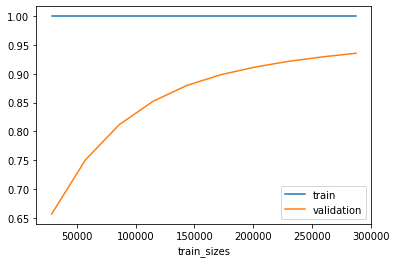

In [225]:
plt.plot(N, train_score.mean(axis=1), label='train')
plt.plot(N, val_score.mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.legend()
plt.show()

# Logistic regression

Our problem is a very binary one : will someone repay their credit or won't they ? 

This is why we use logistic regression as our machine learning model.

In [242]:
LR = LogisticRegression()

## LR - Model training

In [243]:
LR.fit(X_train, y_train)

LogisticRegression()

## LR - Model testing

In [244]:
y_pred = LR.predict(X_test)
print("Predictions:\n\n", y_pred, '\n')
print("Real values:\n\n", y_test)

Predictions:

 [1. 1. 0. ... 0. 0. 1.] 

Real values:

 47925    1.0
10986    0.0
47280    1.0
27057    1.0
43300    1.0
        ... 
39397    1.0
15167    0.0
28546    1.0
23755    0.0
44535    1.0
Name: TARGET, Length: 10501, dtype: float64


## LR - Model evaluation

### LR - Confusion Matrix

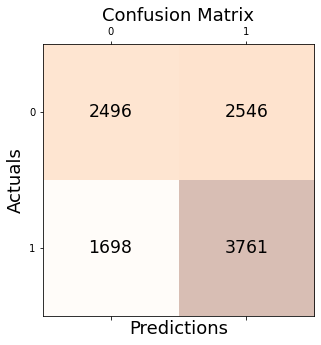

The confusion matrix shows us the number of :

* True positives : 2496 

* True negatives : 2546 

* False positives: 1698 

* False negatives: 3761 



In [245]:
conf_matrix = metrics.confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

print('The confusion matrix shows us the number of :\n')
print('* True positives :', conf_matrix[0][0] ,'\n')
print('* True negatives :', conf_matrix[0][1],'\n')
print('* False positives:', conf_matrix[1][0] ,'\n')
print('* False negatives:', conf_matrix[1][1] ,'\n')

### LR - Classification Report

In [187]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.58      0.48      0.52     57576
         1.0       0.59      0.69      0.63     62160

    accuracy                           0.58    119736
   macro avg       0.58      0.58      0.58    119736
weighted avg       0.58      0.58      0.58    119736



### LR - Accuracy Score

In [188]:
print("Accuracy score:", round((accuracy_score(y_test, y_pred)*100), 3), '%\n')
print("Accuracy score using cross validation:", 
      round((cross_val_score(LR, X_train, y_train, cv=3, scoring='accuracy').mean())*100, 2), '%\n')

Accuracy score: 58.484 %

Accuracy score using cross validation: 58.72 %



Model accuracy is a machine learning model performance metric that is defined as the ratio of true positives and true negatives to all positive and negative observations.

The accuracy rate is great but it doesn’t tell us anything about the errors our machine learning models make on new data we haven’t seen before.

Mathematically, it represents the ratio of the sum of true positive and true negatives out of all the predictions.

### LR - Precision Score

In [189]:
print("Precision score:", round((precision_score(y_test, y_pred, average='macro')*100), 2), '%\n')

Precision score: 58.46 %



The precision score is a useful measure of the success of prediction when the classes are very imbalanced.

Mathematically, it represents the ratio of true positive to the sum of true positive and false positive.

### LR - Recall Score

In [190]:
print("Recall score:", round((metrics.recall_score(y_test, y_pred)*100), 2), '%\n')

Recall score: 68.51 %



Model recall score represents the model’s ability to correctly predict the positives out of actual positives. This is unlike precision which measures how many predictions made by models are actually positive out of all positive predictions made.

Recall score is a useful measure of success of prediction when the classes are very imbalanced. 

Mathematically, it represents the ratio of true positive to the sum of true positive and false negative.

### LR - F1 Score

In [191]:
print("F1 Score:", round((metrics.f1_score(y_test, y_pred))*100), 2, '%\n')

F1 Score: 63 2 %



F1-score is harmonic mean of precision and recall score and is used as a metrics in the scenarios where choosing either of precision or recall score can result in compromise in terms of model giving high false positives and false negatives respectively.

### LR - ROC Curve

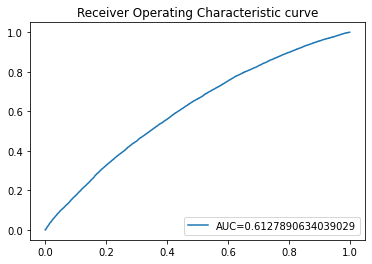

In [192]:
prediction_prob = LR.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  prediction_prob)
auc = metrics.roc_auc_score(y_test, prediction_prob)

#create ROC curve
plt.title("Receiver Operating Characteristic curve")
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.show()

This curve displays the percentage of true positives predicted by the model as the prediction probability cutoff is lowered from 1 to 0.

The higher the AUC (area under the curve), the more accurately our model is able to predict outcomes.

## LR - Learning Curve

In [231]:
N, train_score, val_score = learning_curve(LR, 
                                           X_train, 
                                           y_train,
                                           train_sizes = np.linspace(0.1, 1.0, 10),
                                           cv=5)

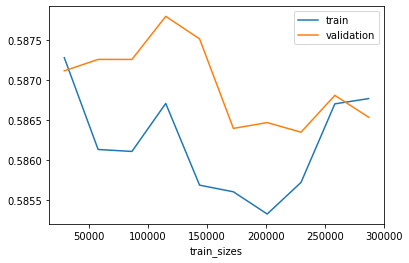

In [232]:
plt.plot(N, train_score.mean(axis=1), label='train')
plt.plot(N, val_score.mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.legend()
plt.show()

## Using our LR model on application test

In [193]:
app_test_LR = app_test.copy()
app_test_LR['TARGET'] = 0

Application test doesn't have a TARGET column. 

That's why after the prediction, we can not see if our model finds the right value.

In [194]:
y_pred_test = LR.predict(app_test_LR)
app_test_LR['TARGET'] = y_pred_test.astype(int)
print(app_test_LR['TARGET'])

0        1
1        0
2        1
3        0
4        0
        ..
48739    1
48740    1
48741    1
48742    0
48743    1
Name: TARGET, Length: 39470, dtype: int32


# Decision Tree

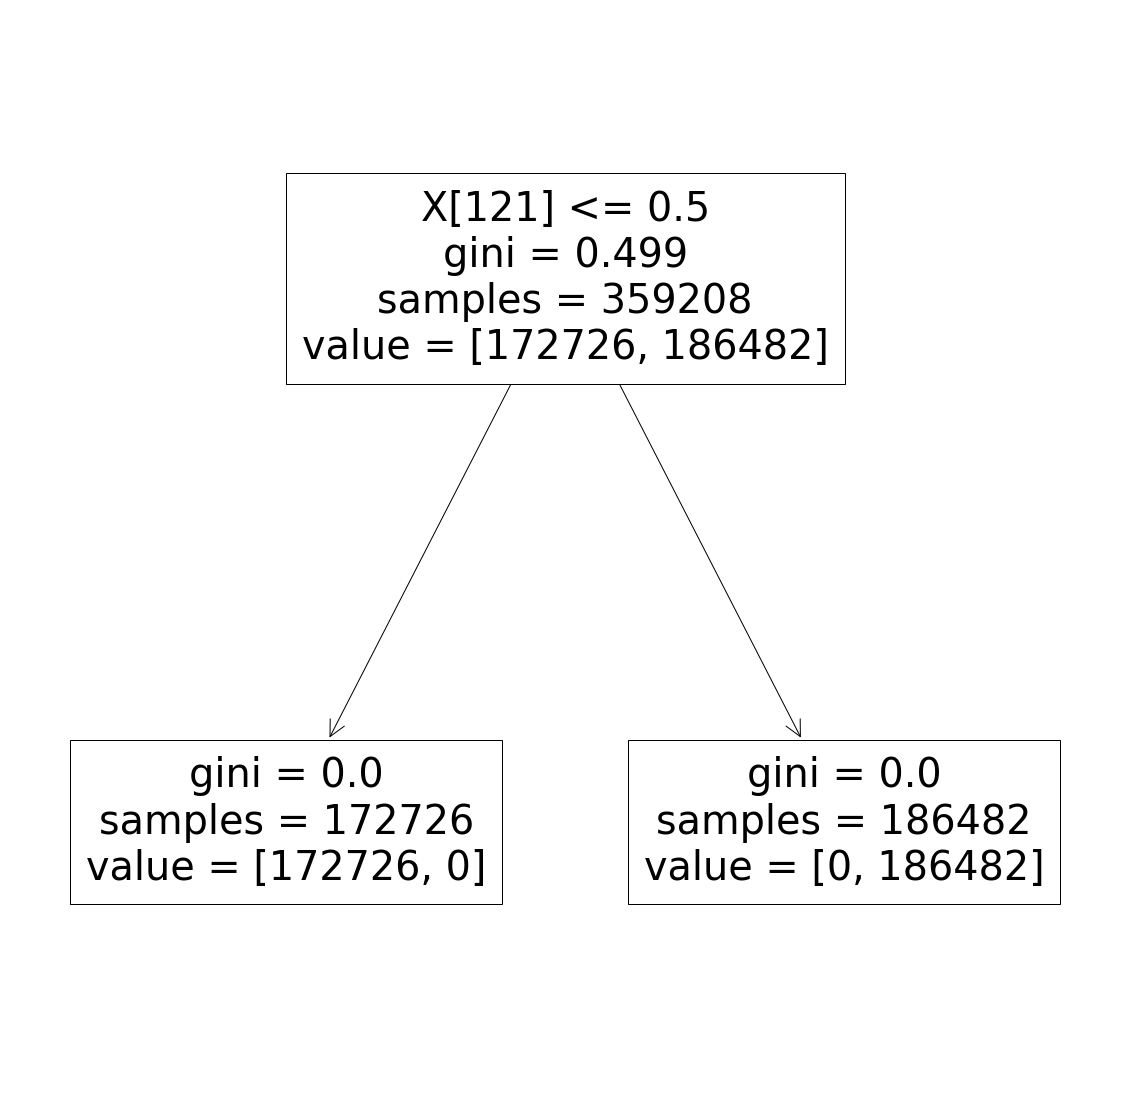

In [195]:
DT = DecisionTreeClassifier(criterion='gini')
DT.fit(X_train, y_train)
plt.figure(figsize=(20,20))
tree.plot_tree(DT)
plt.show()

## DT - Model testing

In [196]:
y_pred = DT.predict(X_test)
print("Predictions:\n\n", y_pred, '\n')
print("Real values:\n\n", y_test)

Predictions:

 [1. 0. 1. ... 1. 0. 0.] 

Real values:

 [1. 0. 1. ... 1. 0. 0.]


## DT - Model evaluation

### DT - Confusion Matrix

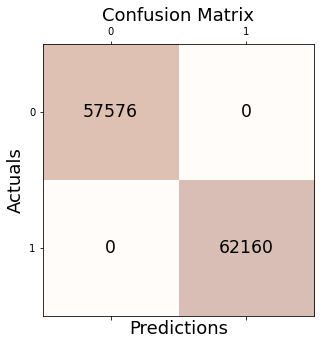

The confusion matrix shows us the number of :

* True positives : 57576 

* True negatives : 0 

* False positives: 0 

* False negatives: 62160 



In [197]:
conf_matrix = metrics.confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

print('The confusion matrix shows us the number of :\n')
print('* True positives :', conf_matrix[0][0] ,'\n')
print('* True negatives :', conf_matrix[0][1],'\n')
print('* False positives:', conf_matrix[1][0] ,'\n')
print('* False negatives:', conf_matrix[1][1] ,'\n')

### DT - Classification report

In [198]:
print("Classification report:\n\n", classification_report(y_test, y_pred))

Classification report:

               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     57576
         1.0       1.00      1.00      1.00     62160

    accuracy                           1.00    119736
   macro avg       1.00      1.00      1.00    119736
weighted avg       1.00      1.00      1.00    119736



### DT - Accuracy Score

In [199]:
print("Accuracy score:", round((accuracy_score(y_test, y_pred)*100), 2), '%\n')
print("Accuracy score using cross validation:", 
      round((cross_val_score(DT, X_train, y_train, cv=3, scoring='accuracy').mean())*100, 2), '%\n')

Accuracy score: 100.0 %

Accuracy score using cross validation: 100.0 %



## DT - Learning Curve

In [228]:
N, train_score, val_score = learning_curve(DT, 
                                           X_train, 
                                           y_train,
                                           train_sizes = np.linspace(0.1, 1.0, 10),
                                           cv=5)

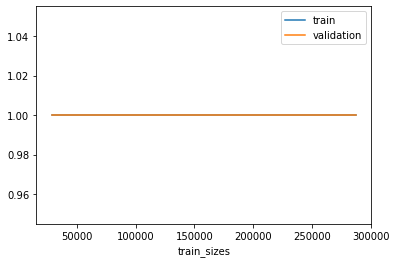

In [229]:
plt.plot(N, train_score.mean(axis=1), label='train')
plt.plot(N, val_score.mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.legend()
plt.show()

## Using our DT model on application test

In [200]:
app_test_DT = app_test.copy()
app_test_DT['TARGET'] = 0

In [201]:
y_pred_test = DT.predict(app_test_DT)
app_test_DT['TARGET'] = y_pred_test.astype(int)
print(app_test_DT['TARGET'])

0        0
1        0
2        0
3        0
4        0
        ..
48739    0
48740    0
48741    0
48742    0
48743    0
Name: TARGET, Length: 39470, dtype: int32


# Random Forest

In [202]:
RF = RandomForestClassifier()

In [203]:
RF.fit(X_train, y_train)

RandomForestClassifier()

## RF - Model testing

In [204]:
y_pred = RF.predict(X_test)
print("Predictions:\n\n", y_pred, '\n')
print("Real values:\n\n", y_test)

Predictions:

 [1. 0. 1. ... 1. 0. 0.] 

Real values:

 [1. 0. 1. ... 1. 0. 0.]


## RF - Model evaluation

### RF - Confusion Matrix

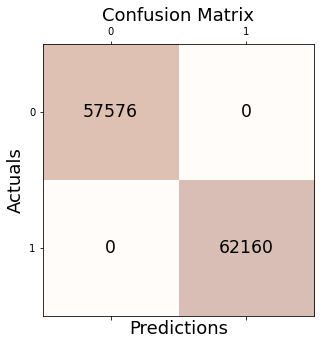

The confusion matrix shows us the number of :

* True positives : 57576 

* True negatives : 0 

* False positives: 0 

* False negatives: 62160 



In [205]:
conf_matrix = metrics.confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

print('The confusion matrix shows us the number of :\n')
print('* True positives :', conf_matrix[0][0] ,'\n')
print('* True negatives :', conf_matrix[0][1],'\n')
print('* False positives:', conf_matrix[1][0] ,'\n')
print('* False negatives:', conf_matrix[1][1] ,'\n')

### RF - Classification Report

In [206]:
print("Classification report:", classification_report(y_test, y_pred))

Classification report:               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     57576
         1.0       1.00      1.00      1.00     62160

    accuracy                           1.00    119736
   macro avg       1.00      1.00      1.00    119736
weighted avg       1.00      1.00      1.00    119736



### RF -  Accuracy Score

In [207]:
print("Accuracy score:", round((accuracy_score(y_test, y_pred)*100), 2), '%\n')
print("Accuracy score using cross validation:", 
      round((cross_val_score(RF, X_train, y_train, cv=3, scoring='accuracy').mean())*100, 2), '%\n')

Accuracy score: 100.0 %

Accuracy score using cross validation: 100.0 %



## RF - Learning Curve

In [230]:
N, train_score, val_score = learning_curve(RF, 
                                           X_train, 
                                           y_train,
                                           train_sizes = np.linspace(0.1, 1.0, 10),
                                           cv=5)

KeyboardInterrupt: 

In [ ]:
plt.plot(N, train_score.mean(axis=1), label='train')
plt.plot(N, val_score.mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.legend()
plt.show()

## Using our RF model on application test

In [208]:
app_test_RF = app_test.copy()
app_test_RF['TARGET'] = 0

In [209]:
y_pred_test = RF.predict(app_test_RF)
app_test_RF['TARGET'] = y_pred_test.astype(int)
print(app_test_RF['TARGET'])

0        0
1        0
2        0
3        0
4        0
        ..
48739    0
48740    0
48741    0
48742    0
48743    0
Name: TARGET, Length: 39470, dtype: int32


# XGBoost

In [210]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

## XGBoost - Model training

In [211]:
param = {
    'max_depth': 3,  # the maximum depth of each tree
    'eta': 0.3,  # the training step for each iteration
    'silent': 1,  # logging mode - quiet
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 3}  # the number of classes that exist in this datset
num_round = 20  # the number of training iterations
XGBst = xgb.train(param, dtrain, num_round)

[16:06:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:06:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [212]:
"""
XGBst.dump_model('dump.raw.txt')
f = open('dump.raw.txt', 'r')
print(f.read())
"""

booster[0]:
0:[f121<0.5] yes=1,no=2,missing=1
	1:leaf=0.449994147
	2:leaf=-0.224997312
booster[1]:
0:[f121<0.5] yes=1,no=2,missing=1
	1:leaf=-0.224997088
	2:leaf=0.449994594
booster[2]:
0:leaf=-0.224998608
booster[3]:
0:[f121<0.5] yes=1,no=2,missing=1
	1:leaf=0.302744657
	2:leaf=-0.200604156
booster[4]:
0:[f121<0.5] yes=1,no=2,missing=1
	1:leaf=-0.200603977
	2:leaf=0.302744836
booster[5]:
0:leaf=-0.200605482
booster[6]:
0:[f121<0.5] yes=1,no=2,missing=1
	1:leaf=0.24233368
	2:leaf=-0.185299397
booster[7]:
0:[f121<0.5] yes=1,no=2,missing=1
	1:leaf=-0.185299188
	2:leaf=0.242333815
booster[8]:
0:leaf=-0.185300842
booster[9]:
0:[f121<0.5] yes=1,no=2,missing=1
	1:leaf=0.210205182
	2:leaf=-0.175068453
booster[10]:
0:[f121<0.5] yes=1,no=2,missing=1
	1:leaf=-0.17506817
	2:leaf=0.210205317
booster[11]:
0:leaf=-0.175070167
booster[12]:
0:[f121<0.5] yes=1,no=2,missing=1
	1:leaf=0.190954134
	2:leaf=-0.16801405
booster[13]:
0:[f121<0.5] yes=1,no=2,missing=1
	1:leaf=-0.168013707
	2:leaf=0.190954342
b

## XGBoost - Model Testing

In [213]:
probs_predictions = XGBst.predict(dtest)
y_pred = np.asarray([np.argmax(line) for line in probs_predictions])
print("Predictions:\n\n", y_pred, '\n')
print("Real values:\n\n", y_test)

Predictions:

 [1 0 1 ... 1 0 0] 

Real values:

 [1. 0. 1. ... 1. 0. 0.]


## XGBoost - Model Evaluation

### XGBoost - Classification Report

In [214]:
print("Classification report:", classification_report(y_test, y_pred))

Classification report:               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     57576
         1.0       1.00      1.00      1.00     62160

    accuracy                           1.00    119736
   macro avg       1.00      1.00      1.00    119736
weighted avg       1.00      1.00      1.00    119736



### XGBoost - Confusion Matrix

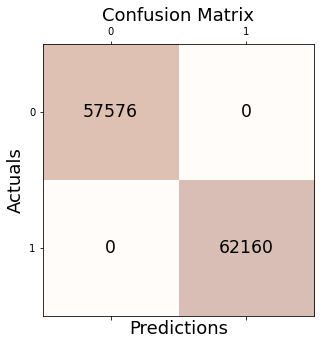

The confusion matrix shows us the number of :

* True positives : 57576 

* True negatives : 0 

* False positives: 0 

* False negatives: 62160 



In [215]:
conf_matrix = metrics.confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

print('The confusion matrix shows us the number of :\n')
print('* True positives :', conf_matrix[0][0] ,'\n')
print('* True negatives :', conf_matrix[0][1],'\n')
print('* False positives:', conf_matrix[1][0] ,'\n')
print('* False negatives:', conf_matrix[1][1] ,'\n')

# Comparing models predictions on application test

In [217]:
LR_target = app_test_LR['TARGET'] 
DT_target = app_test_DT['TARGET']
RF_target = app_test_RF['TARGET']

if DT_target.equals(RF_target):
    print("Decision Tree and Random Forest found the same target values on application test")

if LR_target.equals(DT_target):
    if LR_target.equals(RF_target):
        print("All three models found the same target values on application test.")
else: 
    print("All three models did not find the same target values on application test.")

Decision Tree and Random Forest found the same target values on application test
All three models did not find the same target values on application test.


# Conclusion

The data given was very unbalanced, we had to use oversampling to balance it to get accurate models.

We can see that the least efficient model was the logistic regression.

As the bank, if the model predicts too many true positives, this is not an issue. The bank would not give the loan to someone who could have repaid it. This isn't so great for the clients.